# HW06: ML and Causal Inference (due November 9th)

**As a first part of THIS WEEK'S homework (HW06) you will have to provide feedback to two of your classmates' essays on Eduflow.** On Eduflow, you will be automatically assigned to the two essays you have to provide feedback to on Friday, in case you want to start ahead.

### For the coding part of the homework, you will have to solve only one of the three exercises.

## Exercise 1: Double Machine learning with XGboost

In this exercise you will investigate a research question similar to the one in HW02. Namely, what is the effect of being in a Union on wages? You will use the same data as in HW02 (description of the variables can be found [here](https://rdrr.io/rforge/sampleSelection/man/nlswork.html)). Although, here instead of just including controls, you will estimate the effect of union membership on wages using double machine learning and you will use XGboost as machine learning algorithm. The regression of reference is the following: 

$$ln\_wage_i = \beta_0 + \beta_1 union_i +\varepsilon_i$$

In [ ]:
# Load Data (NLSY)
import pandas as pd
df = pd.read_stata('http://www.stata-press.com/data/r16/nlswork.dta')
df = df.dropna()

In [ ]:
df.head()

In [ ]:
import numpy as np
Y = df['ln_wage']
D = df['union']

In [ ]:
import statsmodels.formula.api as smf

## Run the regression written above


**What could be potential sources of bias (i.e. confounders)?**

In [ ]:
# fill in X with all predictors that are not colliders
X = df[['age', 'year', #TODO ]]

In [ ]:
# split into sample A and sample B
#TODO

# Within each sample, make a validation set for xgboost early stopping
#TODO

In [ ]:
# Step 1. In both samples, train an xgboost regressor model to predict log wages (outcome Y)
# use early stopping.
from xgboost import XGBRegressor
xgbr_a = XGBRegressor()
xgbr_b = XGBRegressor()


In [ ]:
# Step 2. In both samples, train an xgboost classifier model to predict union status (treatment D)
# use early stopping.
from xgboost import XGBClassifier
xgbc_a = XGBClassifier()
xgbc_b = XGBClassifier()

In [ ]:
# Step 3. Cross-fitting: Form predictions in other sample.

# predict wages in sample A using model trained in sample B:
Y_hat_A = #TODO

# vice versa:
#TODO
    
# predict union status in sample A using model trained in sample B:
#TODO
    
# vice versa:
#TODO
    

Recall that residuals for a variable $Z_i$ are computed as follows:

<center>$\tilde{Z}_i = Z_i - \hat{Z}_i$</center>

where $\hat{Z}_i$ is the predicted value of $Z_i$

In [ ]:
# Compute residuals for wages and union status.

# residualized wages in samples A and B:
y_tilde_A =  #TODO
y_tilde_B =  #TODO

# residualized union status in samples A and B:
D_tilde_A =  #TODO
D_tilde_B =  #TODO

In [ ]:
# Step 4. Run OLS regressions of the residualized variables and produce Double ML estimate
## use robust standard errors 


res_A = smf.OLS()
beta_A = res_A.params
se_A = res_A.bse

res_B = smf.OLS()
beta_B = res_B.params
se_B = result_B.bse

##Take the average of the two coefficient and standard errors and show the result


**Compare the estimates form this and the previous regression. How do these change?**

**Interpret the coefficient from the double ml approach. Can it be interpreted as causal?**

## Exercise 2: Synthetic Control Method

In this exercise we will investigate the economic effects of conflict by focusing on the Basque Country. In particular, we will focus on terrorist conflicts in late 1960's in this area and use as comparison group all other regions of Spain that did not experience terrorism. The (raw) reference regression is the following:

$$gdpcap_r = \beta_0 + \beta_1 terrorism_r + \varepsilon_r$$

where $gdpcap_r$ is GDP per capita in region $r$ and $terrorism_r$ is a dummy equal to 1 if terrorist conflict happened in that region.

In [ ]:
##note that to work correctly you will also have to downgrade scipy to version 1.4.1
!pip install scipy==1.4.1
!pip install SyntheticControlMethods

#restart the kernel after downrgading scipy

In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

style.use("fivethirtyeight")

In [6]:
df = pd.read_csv('data/HW06_data_scm.csv')
del df['Unnamed: 0']
del df['regionno']
df = df.loc[df["regionname"] != "Spain (Espana)"] 

df['terrorism'] = df['regionname']=='Basque Country (Pais Vasco)'
df['terrorism'] = df['terrorism'].astype('int')
df.head()

,regionname,year,gdpcap,sec.agriculture,sec.energy,sec.industry,sec.construction,sec.services.venta,sec.services.nonventa,school.illit,school.prim,school.med,school.high,school.post.high,popdens,invest,terrorism
43,Andalucia,1955,1.688732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
44,Andalucia,1956,1.758498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
45,Andalucia,1957,1.827621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
46,Andalucia,1958,1.852756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
47,Andalucia,1959,1.878035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


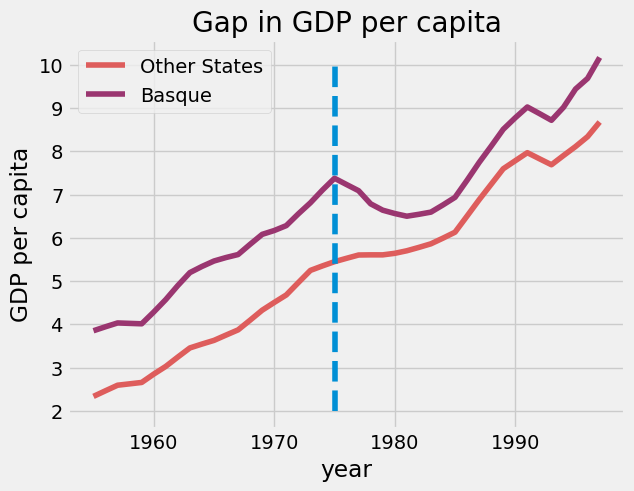

In [7]:
import seaborn as sns

##plot gdp per capita over time separately for basque country and other regions of spain
## (i.e., separately for terrorism == 1 or 0)

palette = sns.color_palette("flare", 2)
plot = sns.lineplot(data=df, x='year', y='gdpcap', hue='terrorism', palette=palette, ci=None)

plot.vlines(x=1975, ymin=2, ymax=10, linestyle="dashed")
plt.ylabel("GDP per capita")
plt.title("Gap in GDP per capita")
plot.legend_.set_title('')
new_labels = ['Other States', 'Basque']
for t, l in zip(plot.legend_.texts, new_labels):
    t.set_text(l)

**Does the parallel trend assumption hold? If not, why do you think this is the case?**

The GDP per capita in Basque Country and other states evolve relatively similar before 1975. However, in the last years before 1975, the economy in Basque County grows faster than in other counties. Not accounting for this would lead to an overestimation of the effect of terrorism on gdp.

In [8]:
## run a regression of terrorism on gdp per capita
df['post'] = (df['year']>1975).astype('int')
df['terr_post'] = df['post']*df['terrorism']
did = smf.ols('gdpcap ~ terrorism + post + terr_post', data=df).fit()
did.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 gdpcap   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     214.9
Date:                Tue, 08 Nov 2022   Prob (F-statistic):          8.83e-100
Time:                        16:05:22   Log-Likelihood:                -1402.1
No. Observations:                 731   AIC:                             2812.
Df Residuals:                     727   BIC:                             2831.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7473      0.090     41.584      0.000       3.570       3.924
terrorism      1.6349      0.372      4.400      0.000       0.905       2.364
post           3.0703      0.126     24.371      0.000       2.823       3.318
terr_post     -0.5859      0.519     -1.128      0.260      -1.606       0.434
==============================================================================
Omnibus:                       40.246   Durbin-Watson:                   0.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.747
Skew:                           0.610   Prob(JB):                     1.16e-10
Kurtosis:                       3.109   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**What could be potential threats to a causal interpretation of this result?**

As argued above, GDP per capita has been increasing more in Basque County than in other counties before the start of the attacks, so the parallel trend assumption does not hold. The negative effect is therefore likely overestimated.

In [9]:
from SyntheticControlMethods import Synth, DiffSynth
del df['terrorism']

##fit the synthetic control 
sc = Synth(df, outcome_var='gdpcap', id_var='regionname', time_var='year', treatment_period=1975, # time of first observation after the treatment took place
     treated_unit='Basque Country (Pais Vasco)', n_optim=10, # Number of different initialization values for which the optimization is run.
     pen='auto') #  Penalization coefficient 

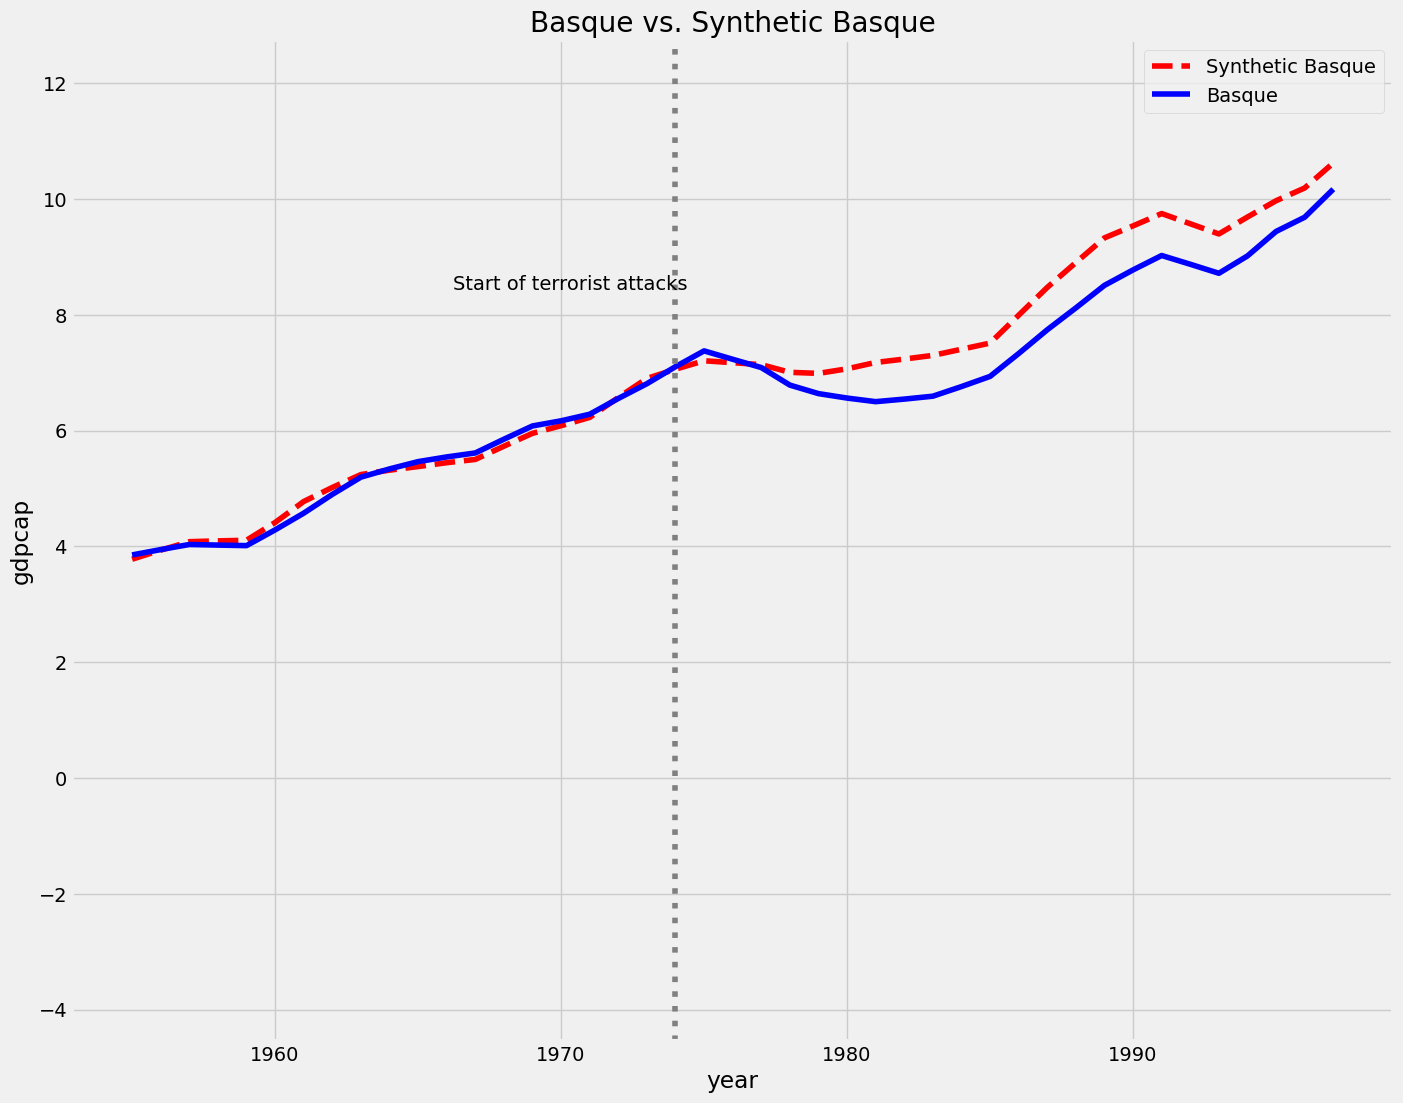

In [10]:
##visualize the plot 
sc.plot(["original"], treated_label="Basque", 
            synth_label="Synthetic Basque", treatment_label="Start of terrorist attacks")

**What can you conclude about the effect of conflict on GDP?**

When controlling for different pre-treatment trends by synthetically constructing a control unit, GDP per capita in Basque County grows less after the terrorist attacks start§.

In [11]:
## Show which spanish regions were used to create the synthetic control

print(sc.original_data.weight_df)

                          Weight
Principado De Asturias  0.090717
Cataluna                0.596210
Madrid (Comunidad De)   0.312838


## Exercise 3: Heterogenous Treatment Effects

In this exercise we will investigate the effect of case management on mental health outcomes. These data come from a randomized control trial where patients were assigned to *intensive* or *standard* case management. In this context, the treatment is being assigned to the **intensive** case management while patients assigned to the **standard** case management belong to the control group..

In this exercise we will focus on heterogenous treatment effects, rather than on isolating the casual effect of the treatment. In particular, we will investigate characteristics of individuals who are most and least responsive to the treatment, i.e., to being assigned to the intensive case management. 

In [ ]:
df = pd.read_stata('http://www.homepages.ucl.ac.uk/~rmjwiww/stata/missing/uk500.dta')
df = df.dropna()
pd.read_stata('http://www.homepages.ucl.ac.uk/~rmjwiww/stata/missing/uk500.dta', iterator=True).variable_labels()

In [ ]:
df.head()

The treatment variable is $rand$, the post-treatment outcomes are $hos96$, $cprs96$ and $sat96$.

In [ ]:
treatvar = 'rand'
df[treatvar].value_counts()

In [ ]:
outcomes = ['sat96', 'hos96', 'cprs96']
df[outcomes].describe()

In addition to these variables we need a set of covariates that we want to use to identify individuals who are most and least responsive to treatment. We also encode categorical covariates and prepare them for the ML model

In [ ]:
#Encoding Categorical covariates and preparing the data for tensorflow
covariates = ['status', 'sex', 'sat94', 'ocfabth', 'hos94', 'das94', 'cprs94', 'age', 'afcarib']
covariates_cat = ['status', 'sex', 'ocfabth', 'afcarib']

from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df[covariates_cat] = encoder.fit_transform(df[covariates_cat])
df[covariates] = df[covariates].astype('float32')
df[covariates].head()

In [ ]:
# Subset the dataset by treatment and control
# Within each sample, create a training, a test and a validation set

df_treat = #TODO
df_control = #TODO

In [ ]:
##choose one of the three outcomes to analyze
## using xgboost regressor train two model to predict the outcome from the covariates
## the first model should be trained on the treated sample, while the second on the control
## use early stopping

from xgboost import XGBRegressor
xgbr_treat = XGBRegressor()
xgbr_control = XGBRegressor()

In [ ]:
##get predicted outcomes using the combined test sets for both models 

test_set = Xtreat_test.append(Xcontrol_test) 
y_hat_treat = ...
y_hat_control = ...

In [ ]:
##find the three individuals in the test set that are most and least responsive to the treatment
##namely the three individuals for who the treatment effect is larger and those for who it is smaller

test_set['treat_effect'] = ...

In [ ]:
##visualize and comment on the covariates of these individuals 